Imports

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from TrainGenerator import * 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten, Dropout
from tensorflow.keras.layers import InputLayer, MaxPooling2D, UpSampling2D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

d:\sem 8\FYP_codes_CAE\CAE\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Parameters

In [2]:
batch_size = 100
patch_size = 128
stride = 64

Dataset Paths

In [3]:
image_directory = r'G:\CO4001_eng_project\Dataset\carpet_512by512\train'
Validation_dataset = [] 

bad_images_directory = r'G:\CO4001_eng_project\Dataset\carpet_512by512\test\hole'
bad_dataset = []

In [4]:
good_images = os.listdir(image_directory + '\good_280')

for i, image_name in enumerate(good_images[240:279]):
    if image_name.endswith('.png'):
        image_path = os.path.join(image_directory, 'good_280', image_name)
        image = cv2.imread(image_path)

        if image is not None:
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            Validation_dataset.append(np.array(image))
        else:
            print(f"Failed to load image")


print(len(Validation_dataset))
print(Validation_dataset[0].shape)

Validation_dataset = np.array(Validation_dataset)
print(Validation_dataset.shape)

39
(512, 512, 3)
(39, 512, 512, 3)


In [21]:
Validation_dataset = Validation_dataset.astype('float32') / 255.

Fake dataset

In [4]:
bad_images = os.listdir(bad_images_directory )

for i, image_name in enumerate(bad_images):
    if image_name.endswith('.png'):
        image_path = os.path.join(bad_images_directory, image_name)
        image = cv2.imread(image_path)

        if image is not None:
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            bad_dataset.append(np.array(image))
        else:
            print(f"Failed to load image")


print(len(bad_dataset))
print(bad_dataset[0].shape)

bad_dataset = np.array(bad_dataset)
print(bad_dataset.shape)

17
(512, 512, 3)
(17, 512, 512, 3)


In [5]:
test = bad_dataset

In [6]:
test_generator = DataGenerator(test, patch_size, stride)

833


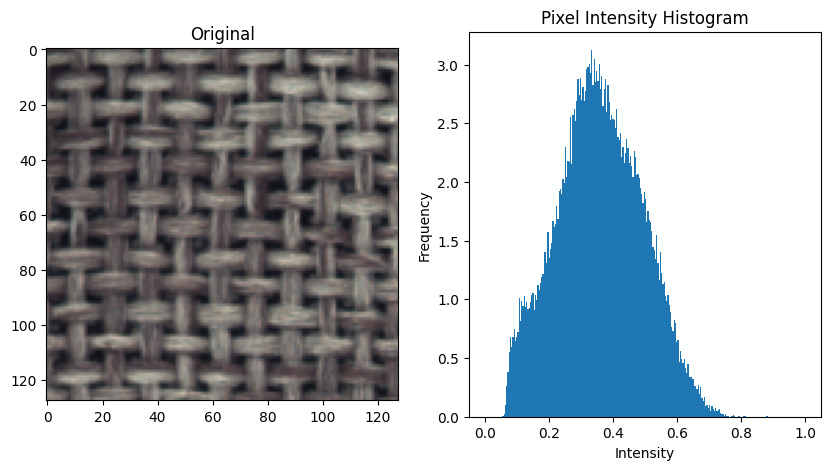

Intensity Range of Sample Image:
Min Intensity: 0.05490196
Max Intensity: 0.88235295


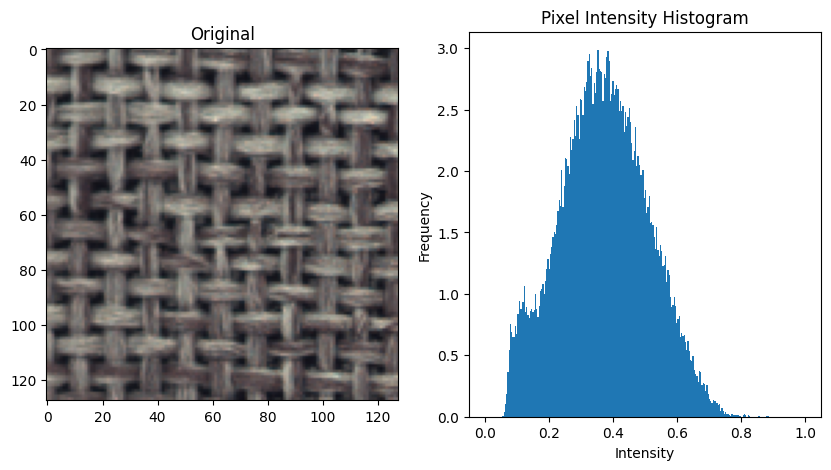

Intensity Range of Sample Image:
Min Intensity: 0.05490196
Max Intensity: 0.8862745


In [10]:
batches = test_generator[0]   # get batches
image_batch_1 = batches[1]      # get a batch of image patches

# print(train_generator.shape)
# print(len(train_generator[0]))
print(len(image_batch_1))
# print(first_image)

first_image = image_batch_1[0] 

# for i, element in enumerate(train_generator[0][0]):
#     print(f"Element {i}: type={type(element)}, shape={getattr(element, 'shape', 'No shape attribute')}")

for image in image_batch_1[0:2]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

    # img
    ax1.imshow(image)
    ax1.set_title('Original')
    # histogram
    ax2.hist(image.ravel(), bins=256, range=(0, 1), density=True)
    ax2.set_title('Pixel Intensity Histogram')
    ax2.set_xlabel('Intensity')
    ax2.set_ylabel('Frequency')

    plt.show()

    min_intensity = np.min(image)
    max_intensity = np.max(image)

    print("Intensity Range of Sample Image:")
    print("Min Intensity:", min_intensity)
    print("Max Intensity:", max_intensity)

Load Model

In [8]:
from alibi_detect.saving import load_detector

filepath = r'D:\sem 8\FYP_codes_CAE\Models\m4'
od = load_detector(filepath)

In [11]:
#infer_threshold Updates threshold by a value inferred from the percentage of 
#instances considered to be outliers in a sample of the dataset.
#percentage of X considered to be normal based on the outlier score.
#Therefor, set it to 99%
od.infer_threshold(image_batch_1[0] , outlier_type='instance', threshold_perc= 90.0)
print("Current threshold value is: ", od.threshold)

ValueError: Exception encountered when calling layer 'encoder_ae' (type EncoderAE).

Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(128, 128, 3)

Call arguments received by layer 'encoder_ae' (type EncoderAE):
  • x=tf.Tensor(shape=(128, 128, 3), dtype=float32)

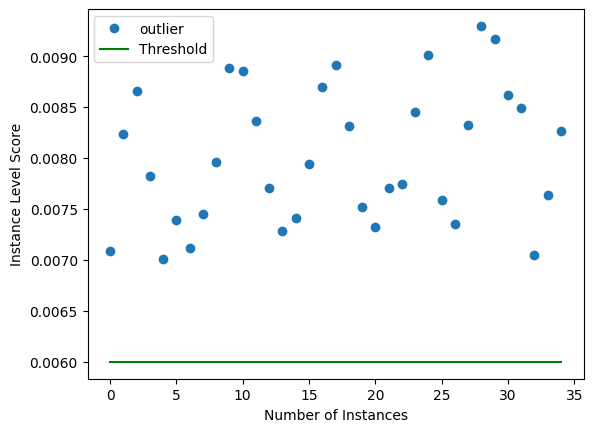

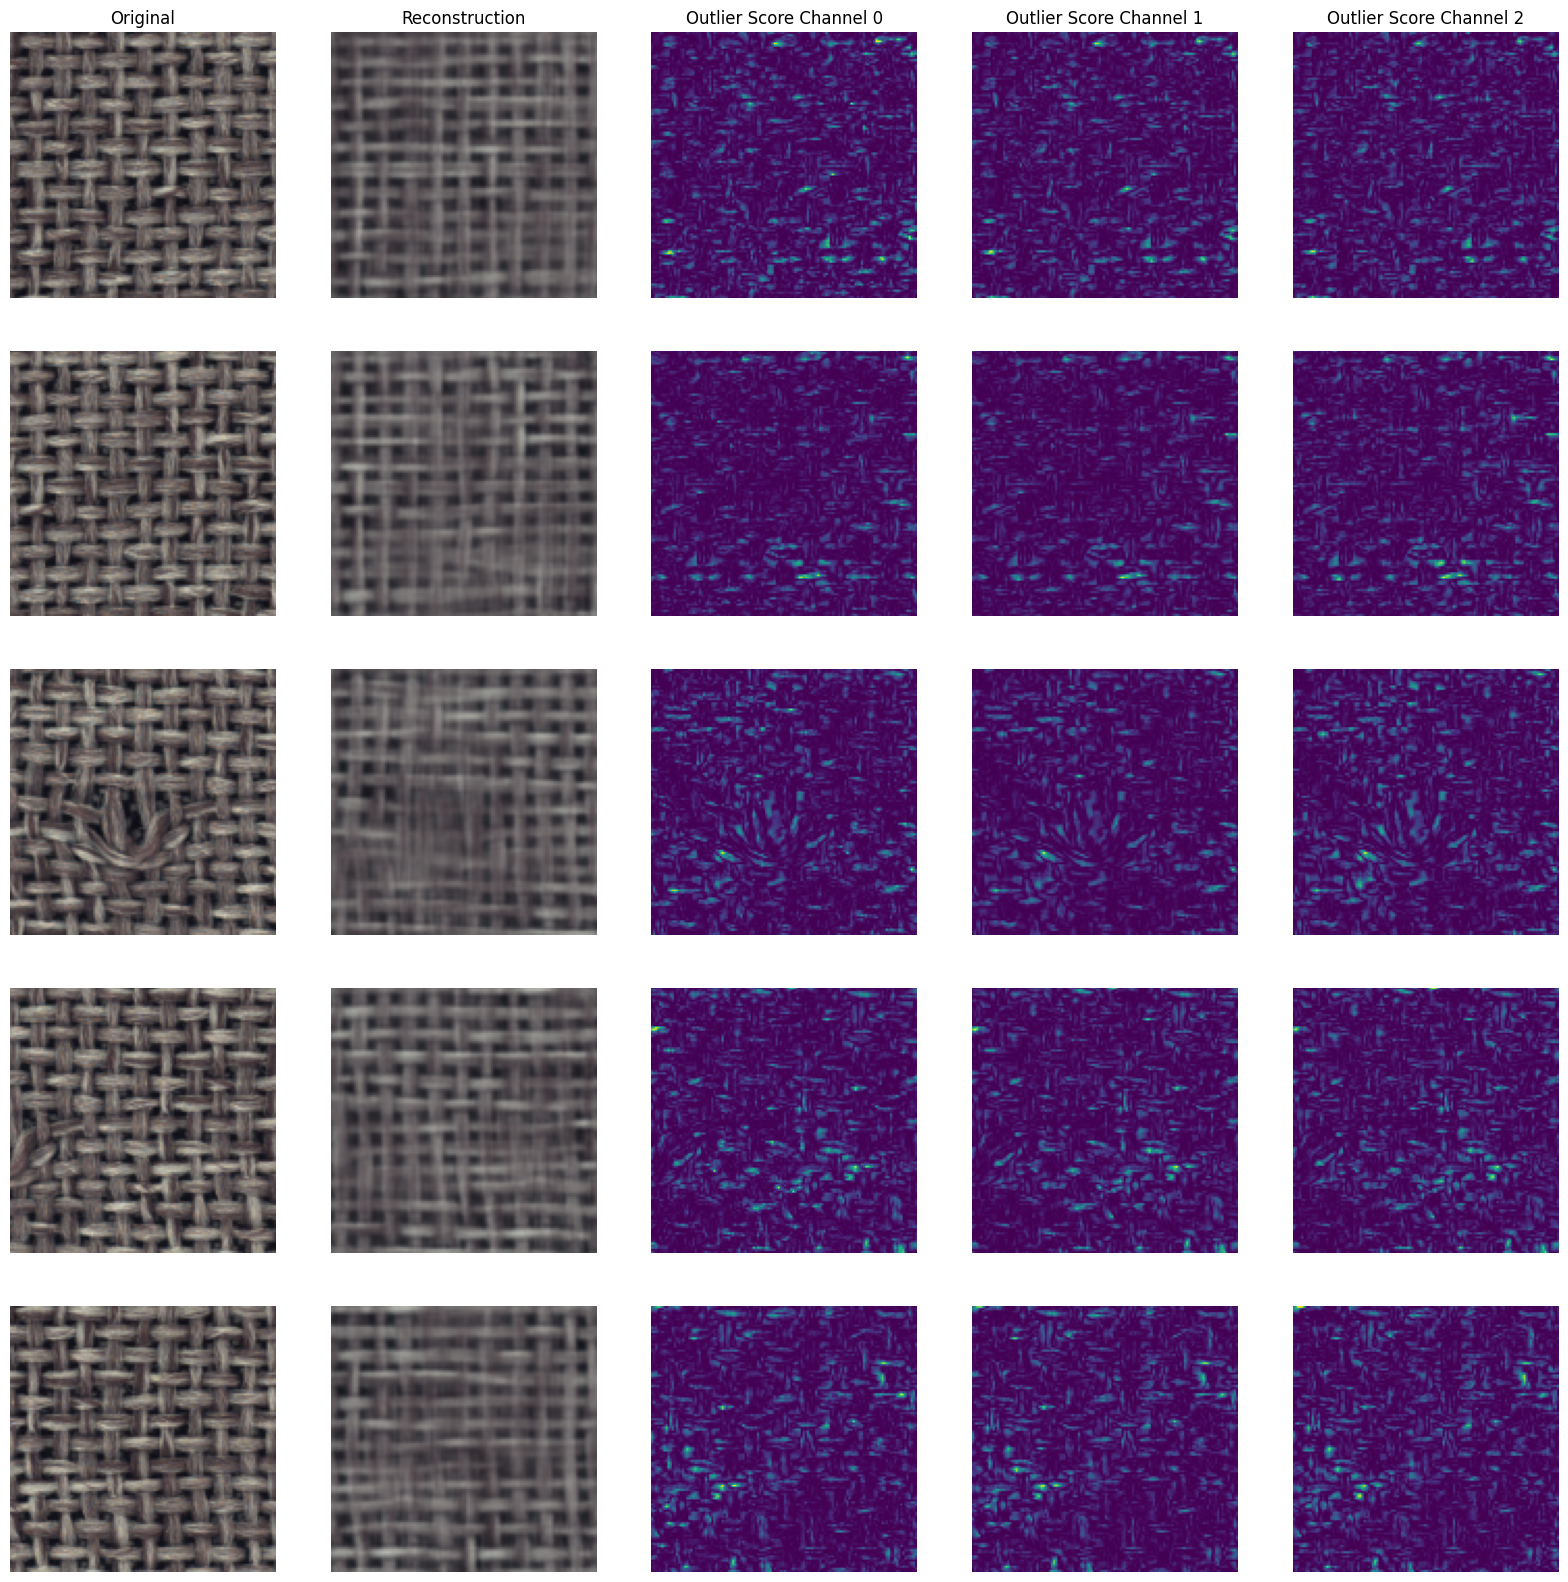

In [12]:
test_set = image_batch_1[:35]

od_preds = od.predict(test_set,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(test_set.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

X_recon = od.ae(test_set).numpy()
plot_feature_outlier_image(od_preds,
                           test_set,
                           X_recon=X_recon,
                           instance_ids=[26, 27, 29, 30, 31],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

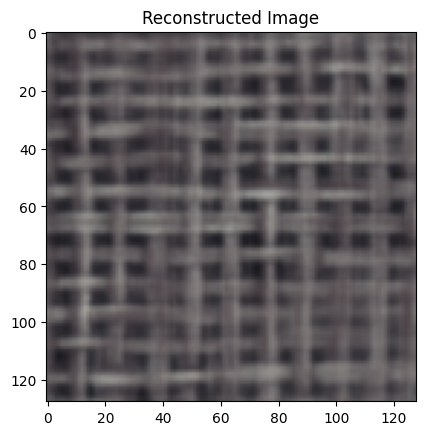

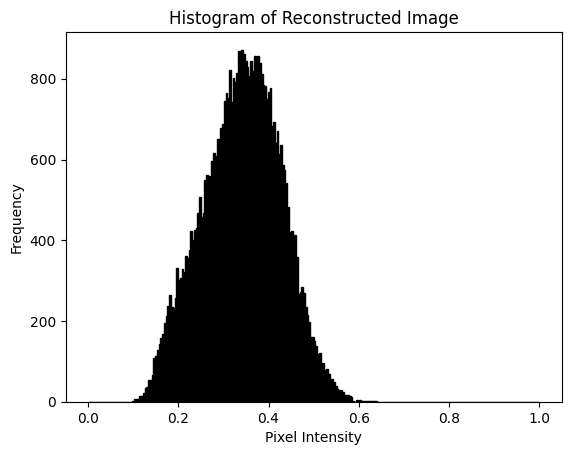

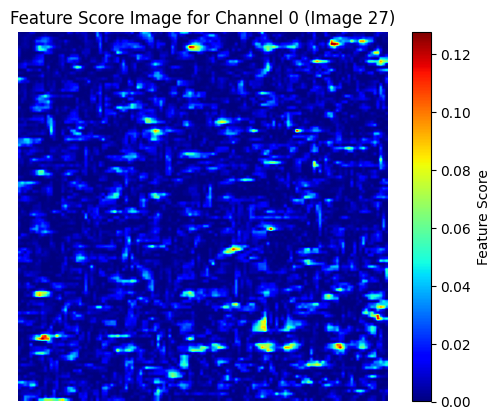

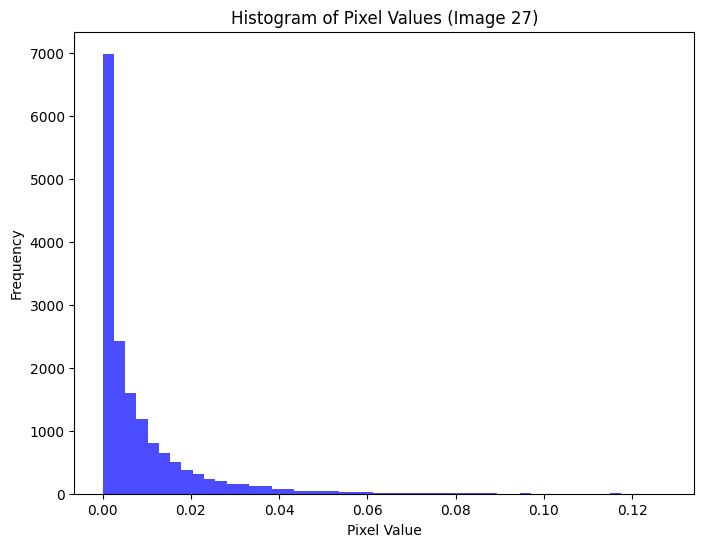

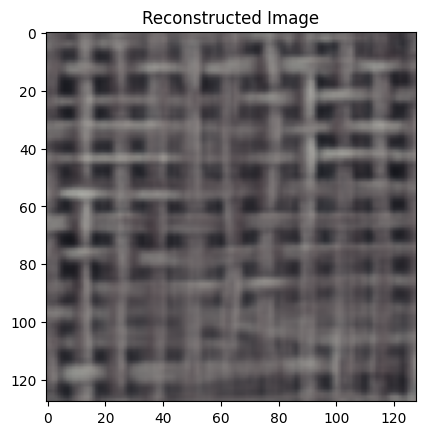

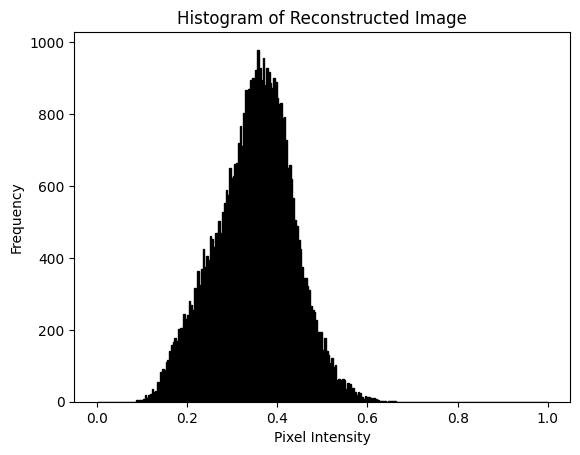

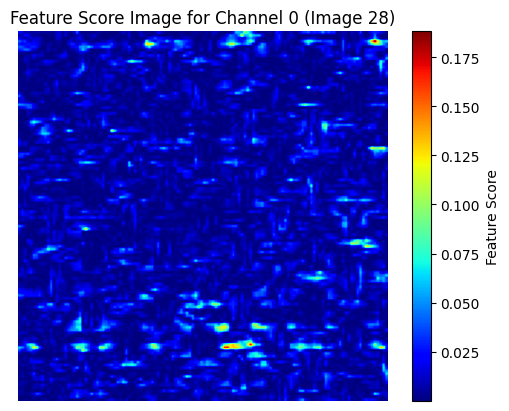

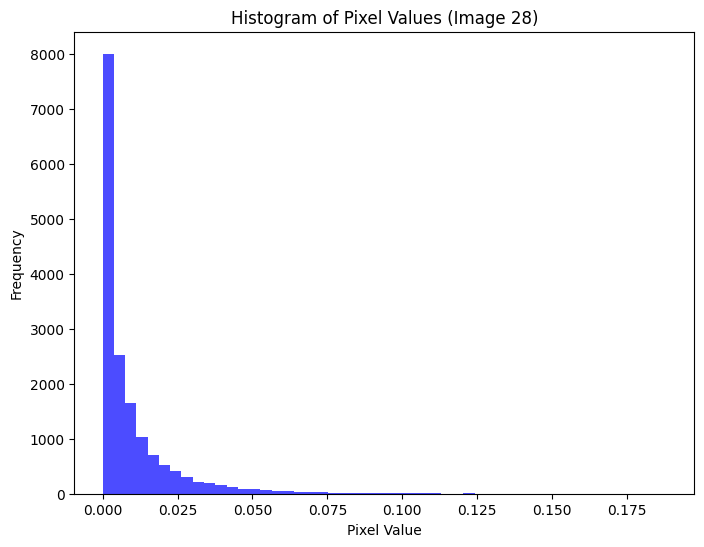

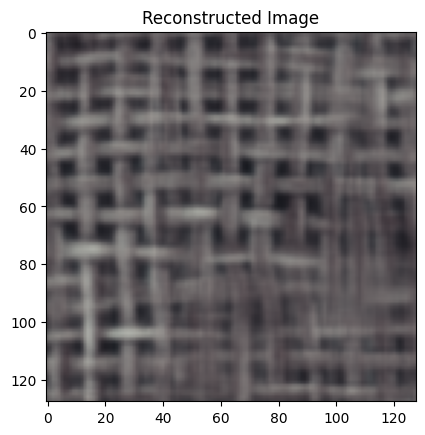

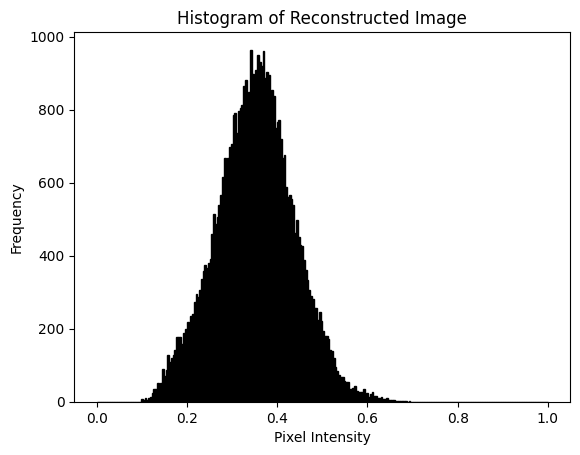

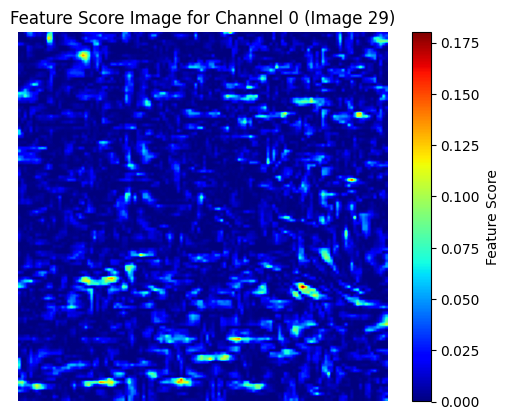

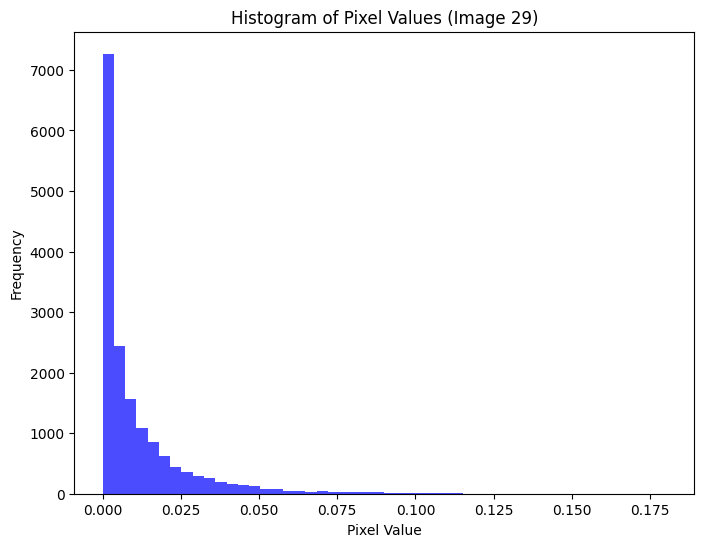

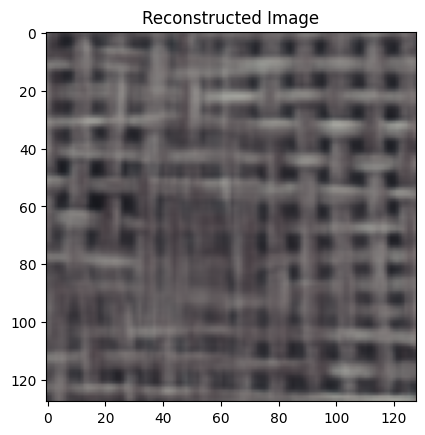

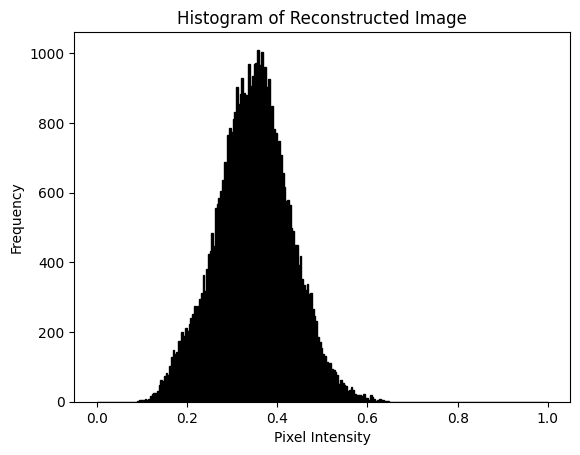

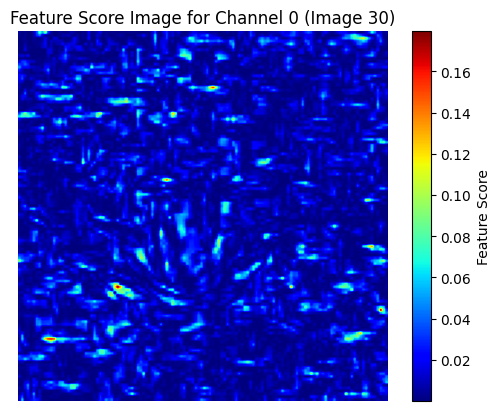

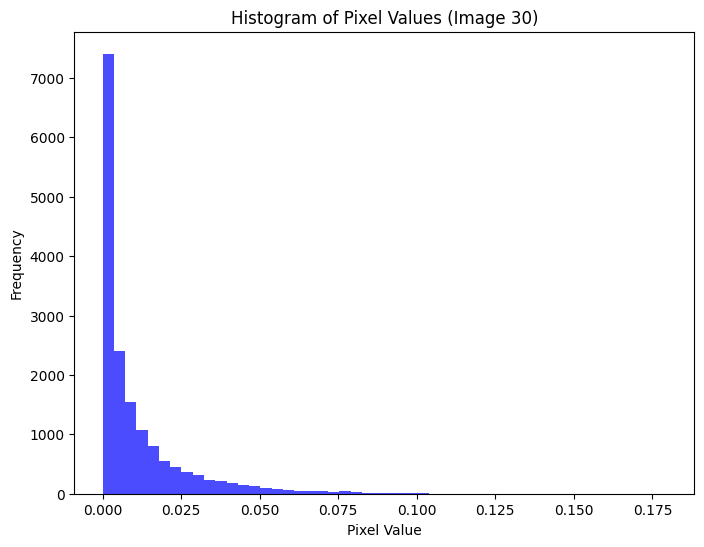

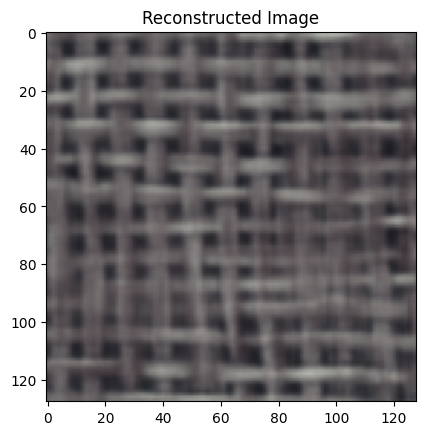

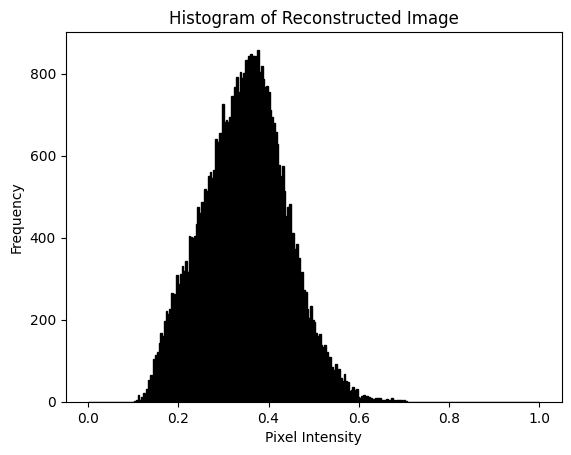

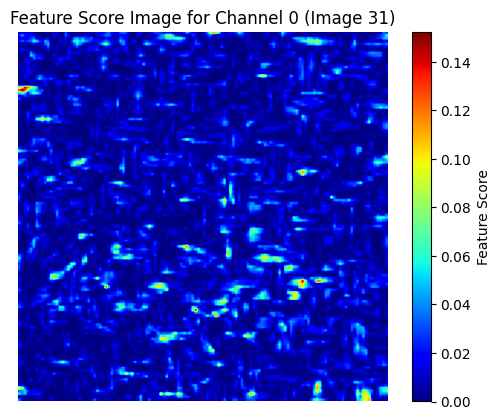

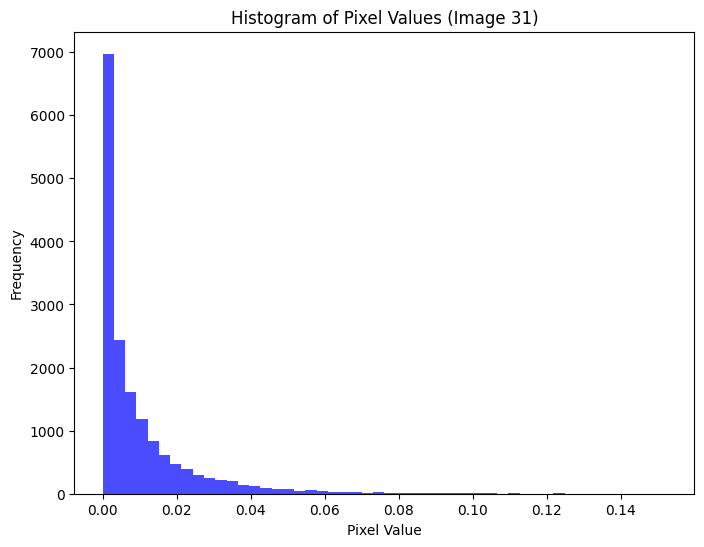

In [12]:
from skimage.transform import resize
# Iterate over the specified range of bad_dataset
for i in range(26, 31):
    test_bad_image = test_set[i].reshape(1, patch_size, patch_size, 3)

    test_bad_image_recon = od.ae(test_bad_image)
    test_bad_image_recon = test_bad_image_recon.numpy()

    test_bad_image_recon[0] = resize(test_bad_image_recon[0], (patch_size, patch_size))

    test_bad_image_predict = od.predict(test_bad_image)

    # bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
    # print(f"The instance score for image {i+1} is:", bad_image_instance_score)

    bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
    
    # Extract the feature score image for channel 0
    bad_image_feature_score_channel_0 = bad_image_feature_score[:, :, 0]

    # Plotting the resized image
    plt.imshow(test_bad_image_recon[0])
    plt.title('Reconstructed Image')
    plt.show()

    # Plotting the histogram of the resized image
    plt.hist(test_bad_image_recon.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
    plt.title('Histogram of Reconstructed Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

    # Plot the image
    plt.imshow(bad_image_feature_score_channel_0, cmap='jet')
    plt.title(f'Feature Score Image for Channel 0 (Image {i+1})')
    plt.colorbar(label='Feature Score')
    plt.axis('off')
    plt.show()

    # Plot the histogram for the pixel values of the image
    plt.figure(figsize=(8, 6))
    plt.hist(bad_image_feature_score_channel_0.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Histogram of Pixel Values (Image {i+1})')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

load defective images

In [24]:

# for root, dirs, files in os.walk(bad_images_directory):
#     for image_name in files:
#         if image_name.endswith('.png'):  # Check if the file is a PNG image
#             image_path = os.path.join(root, image_name)
#             image = cv2.imread(image_path)
#             image = Image.fromarray(image, 'RGB')
#             bad_dataset.append(np.array(image))

# bad_dataset = np.array(bad_dataset)

# # normalize
# bad_dataset = bad_dataset.astype('float32') / 255.
# print(len(bad_dataset))
# print(bad_dataset[0].shape)

17
(128, 128, 3)


In [32]:
img_num = 11
test_bad_image = bad_dataset[img_num].reshape(1, SIZE, SIZE, 3)

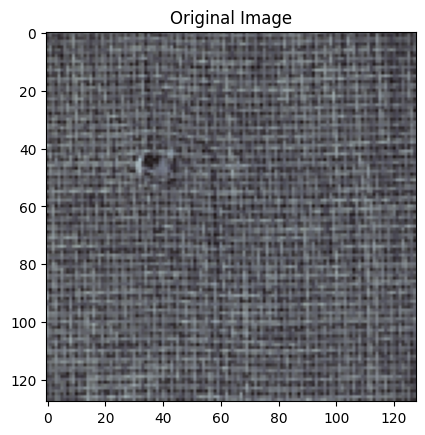

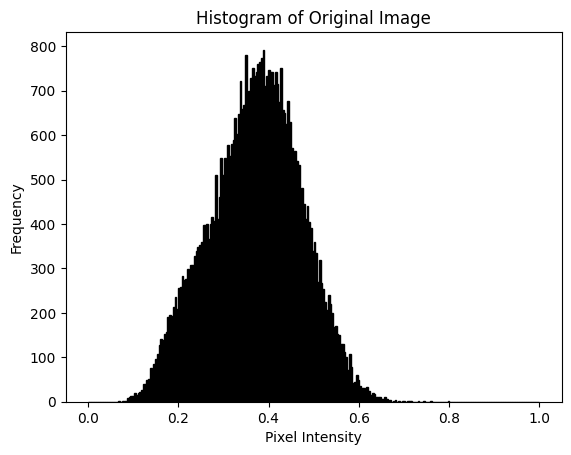

In [33]:
from skimage.transform import resize
import matplotlib.pyplot as plt

# Resizing the original image
resized_image = resize(test_bad_image[0], (SIZE, SIZE))

# Plotting the resized image
plt.imshow(resized_image, cmap='gray')
plt.title('Original Image')
plt.show()

# Plotting the histogram of the resized image
plt.hist(resized_image.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.title('Histogram of Original Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [34]:
from skimage.transform import resize

test_bad_image_recon = od.ae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
test_bad_image_recon[0] = resize(test_bad_image_recon[0], (SIZE, SIZE))

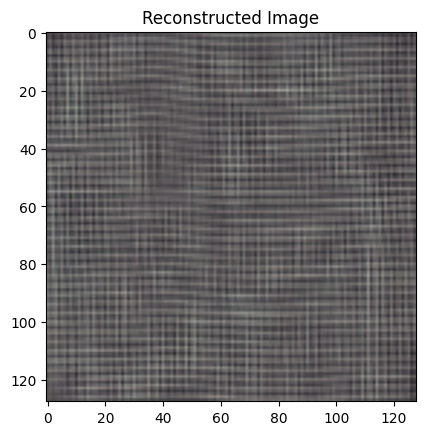

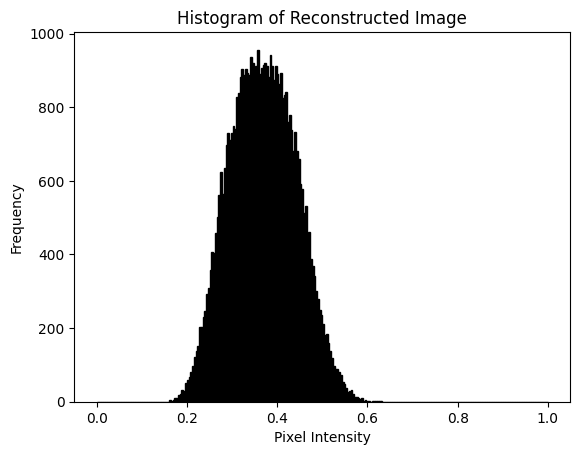

In [35]:
from skimage.transform import resize
import matplotlib.pyplot as plt

# Assuming test_bad_image_recon is already defined as the reconstructed image

# Resizing the reconstructed image
resized_image = resize(test_bad_image_recon[0], (SIZE, SIZE))

# Plotting the resized image
plt.imshow(resized_image, cmap='gray')
plt.title('Reconstructed Image')
plt.show()

# Plotting the histogram of the resized image
plt.hist(resized_image.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.title('Histogram of Reconstructed Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

Predict

In [36]:
test_bad_image_predict = od.predict(test_bad_image)

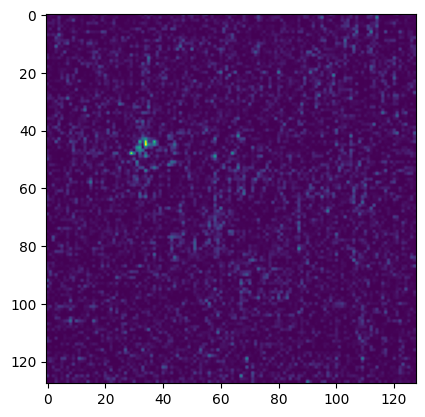

In [37]:
bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])

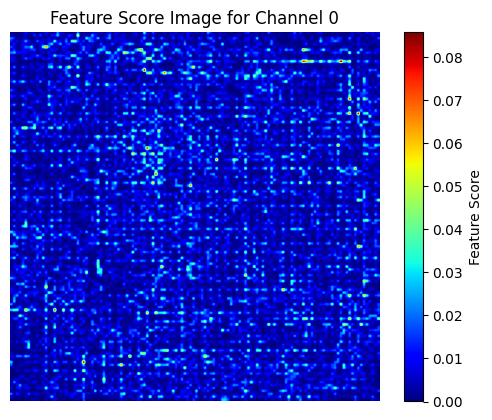

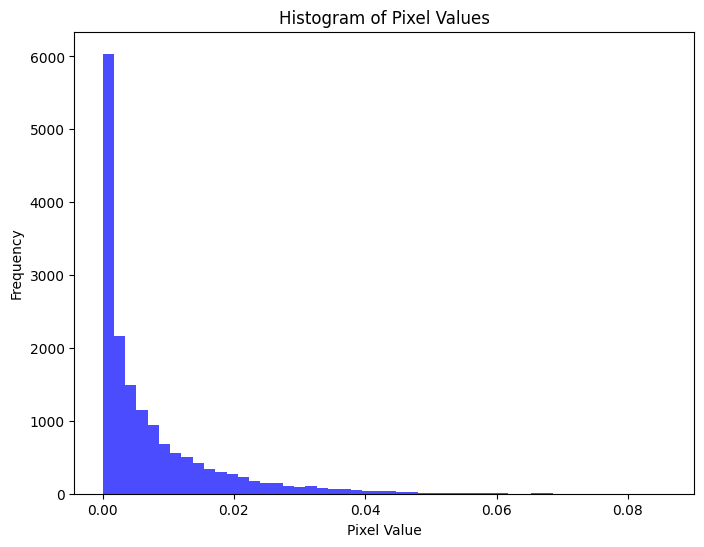

In [31]:
# Extract the feature score image for channel 0
bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0][:, :, 0]

# Plot the image
plt.imshow(bad_image_feature_score, cmap='jet')
plt.title('Feature Score Image for Channel 0')
plt.colorbar(label='Feature Score')
plt.axis('off')
plt.show()

# Plot the histogram for the pixel values of the image
plt.figure(figsize=(8, 6))
plt.hist(bad_image_feature_score.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()